In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV

from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart, cart2pol



import seaborn as sns
import pymc3 as pm
from theano import shared
from theano import tensor as tt

import matplotlib as mpl

import yaml

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


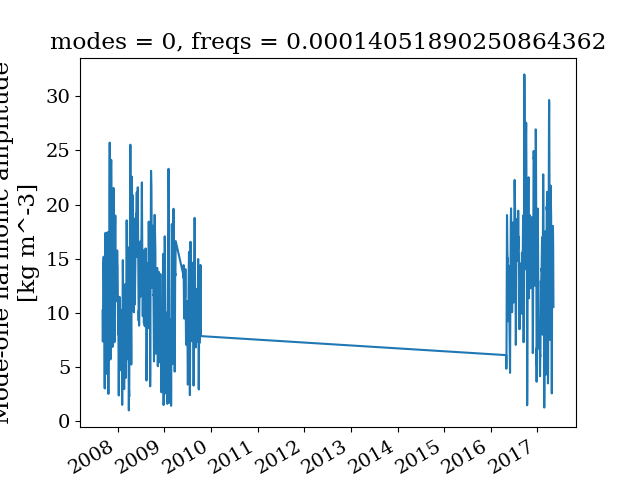

In [6]:
# Load the F-Block data
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/Prelude_Fitted_Buoyancy.nc'
mode=0
H = 500

ds0 = xr.open_dataset(ncfile,group='F_Block_2007_CM04')
ds1 = xr.open_dataset(ncfile,group='F_Block_2008a_CM04')
ds2 = xr.open_dataset(ncfile,group='F_Block_2008b_CM04')
ds3 = xr.open_dataset(ncfile,group='F_Block_2009a_CM04')
ds4 = xr.open_dataset(ncfile,group='F_Block_2009b_CM04')


ncfile2 = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode=0
ds5 = xr.open_dataset(ncfile2,group='KP150_phs1')
ds6 = xr.open_dataset(ncfile2,group='KP150_phs2')


A_n = xr.concat([ds0['A_n'][:,mode],
    ds1['A_n'][:,mode],ds2['A_n'][:,mode],\
                ds3['A_n'][:,mode],ds4['A_n'][:,mode],\
                ds5['A_n'][:,mode],ds6['A_n'][:,mode]],\
                dim='time')

N2 = xr.concat([ds0['N2'][:],
    ds1['N2'][:],ds2['N2'][:],\
                ds3['N2'][:],ds4['N2'][:],\
                ds5['N2'][:],ds6['N2'][:]],\
                dim='timeslow')

cn = xr.concat([ds0['cn'][:,mode],
    ds1['cn'][:,mode],ds2['cn'][:,mode],\
                ds3['cn'][:,mode],ds4['cn'][:,mode],\
               ds5['cn'][:,mode],ds6['cn'][:,mode]],\
               dim='timeslow')

a0 = xr.concat([ds0['amp'][:,0,0],
    ds1['amp'][:,0,0],ds2['amp'][:,0,0],\
    ds3['amp'][:,0,0],ds4['amp'][:,0,0],\
        ds5['amp'][:,0,0],ds6['amp'][:,0,0]],\
        dim='timeslow')

# Quality control
#A_n.loc['2016-09-18':'2016-10-31']=np.nan
#a0.loc['2016-09-18':'2016-10-31']=np.nan

# Create a time series of single days with the max amplitude and a guess at beta
#time1 = pd.date_range('2016-5-1','2016-9-15') 
#time2 = pd.date_range('2016-11-1','2017-5-1')

#time = time1.append(time2)
basetime = datetime(2007,1,1)

#a0_harmonic = a0.sel(timeslow=data.index, method='nearest')
a0_harmonic = a0[::4]
c1 = cn[::4]
N2bar = N2.mean(axis=1)[::4]
tdays_a0 = SecondsSince(a0_harmonic.timeslow.values,basetime=basetime)/86400.
a0_harmonic.timeslow.values
#a0.sel(timeslow=data.index,method='nearest')

plt.figure()
a0_harmonic.plot()

<IPython.core.display.Javascript object>


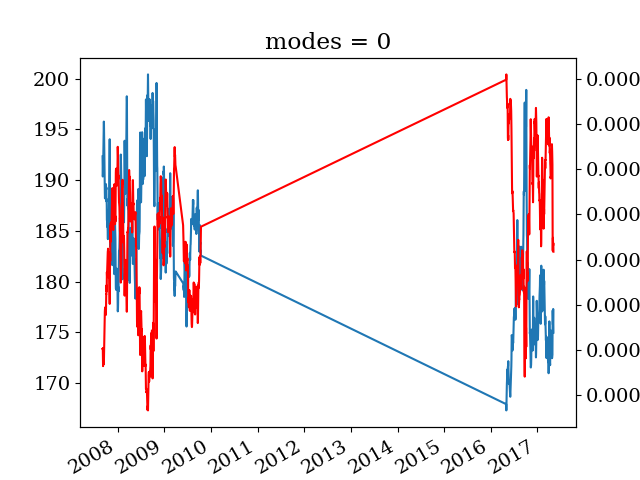

In [7]:
plt.figure()
scalefac = np.sqrt(H*np.sqrt(N2bar)/(N2bar*c1))
scalefac.plot()
ax=plt.twinx()
N2bar.plot(color='r')

# Extract the tides at a point

In [15]:
# Load the tidal velocity
#xpt, ypt = 123.346383, -13.75895
xpt, ypt = 122.6, -13.1


# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']
#tidecons = ['M2','S2','N2','K2',]
#tidecons = ['M2','S2',]

# This extract_phsamp function appears to be wrong so manually calculate the phase and amp

#ua,up,va,vp,ha,hp,omega = readotps.extract_phsamp(tidemod,np.array([xpt]),
#                        np.array([ypt]),basetime, tidecons)
#ha,hp

In [16]:
# Extract the tidal height for the whole period
time = TimeVector('20070801.000000','20091001.000000',3600)
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

#


Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


<IPython.core.display.Javascript object>


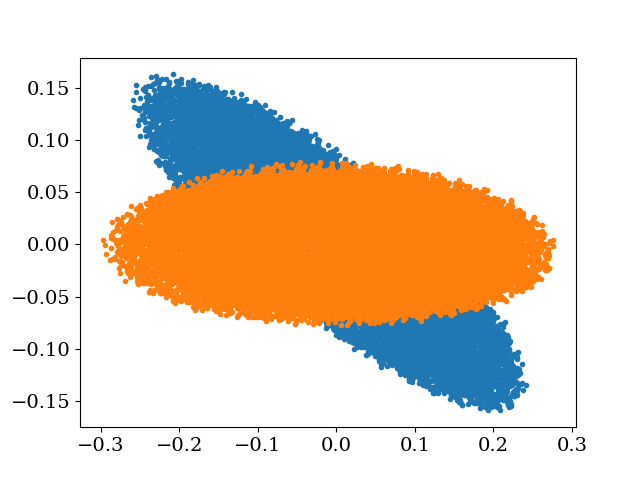

In [17]:
th,sp = cart2pol(U,V)
Ur,Vr = pol2cart(th+30*np.pi/180,sp)

plt.figure()
plt.plot(U,V,'.')
plt.plot(Ur,Vr,'.')

In [18]:
#eta_ts = timeseries(time,eta)
# # Scale the forcing velocity
# H = 500
# Nb = 0.004
# N2 = 0.0001
# cn = 1.5
# scale = np.sqrt(H*Nb/(N2*cn))
# print(scale)
eta_ts = timeseries(time,Ur)


eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

#plt.figure()
#eta_ts.plot()
#plt.plot(time,eta_harmonic)

omega

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


[0.00014051890250864362,
 0.0001454441043328608,
 0.00013787969948654463,
 0.00014584231720055478,
 7.292115835787053e-05,
 6.759774415077306e-05,
 7.252294597499026e-05,
 6.495854112867408e-05]

In [19]:
# Hilbert transform to get the signal envelope
def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    result =0*t
    for ii in range(0,n):
        result += beta_s[2*ii]*np.cos(ff[ii] * t) + beta_s[2*ii+1]*np.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    result_i =  0*t
    for ii in range(0,n):
        result_i += beta_s[2*ii]*np.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*np.sin(ff[ii]*t + np.pi/2)

    return np.abs(result +1j*result_i)


In [20]:
#h_re, h_im = pol2cart(hp,ha)
h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()
beta_s,h_re


(array([ 0.04257409, -0.12821099,  0.05754376,  0.07359529,  0.0141004 ,
        -0.01623942, -0.02991672, -0.01058653,  0.00833805,  0.02472528,
         0.01670069,  0.00406223,  0.00053969,  0.00580387,  0.00133432,
         0.00343102]),
 array([[ 0.04257409,  0.05754376,  0.0141004 , -0.02991672,  0.00833805,
          0.01670069,  0.00053969,  0.00133432]]))

In [21]:
# Compute the tidal envelope at all of our time points
t = a0.timeslow.values
tsec = SecondsSince(t,basetime=basetime)

h_env = sine_model_envelope(beta_s[0:8], omega[0:4], tsec) # M2 only
#h_env += sine_model_envelope(beta_s[8:], omega[4:], tsec)


<IPython.core.display.Javascript object>


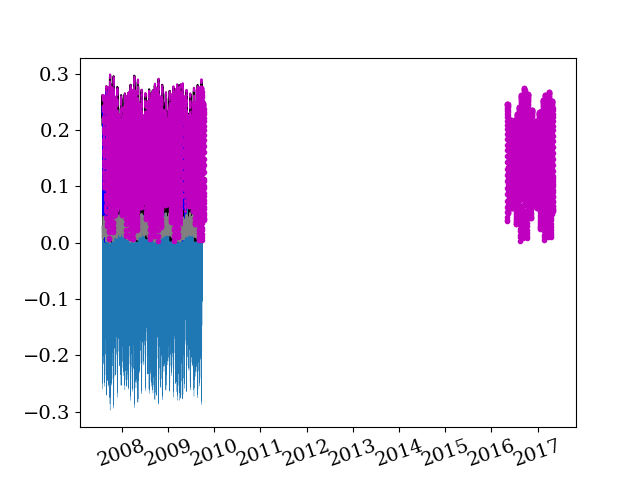

(array([732677., 733042., 733408., 733773., 734138., 734503., 734869.,
        735234., 735599., 735964., 736330.]),
 <a list of 11 Text xticklabel objects>)

In [22]:
t_tides = SecondsSince(eta_ts.t, basetime=basetime)
h_env_full = sine_model_envelope(beta_s, omega, t_tides)
h_D2_full = sine_model_envelope(beta_s[0:8], omega[0:4], t_tides)
h_D1_full = sine_model_envelope(beta_s[8:], omega[4:], t_tides)
h_D1D2_full = h_D2_full+h_D1_full
plt.figure()
plt.plot(eta_ts.t, eta_ts.y.ravel(), lw=0.2)
plt.plot(eta_ts.t, h_env_full,'k')
plt.plot(eta_ts.t, h_D2_full,'b')
plt.plot(eta_ts.t, h_D1_full,'0.5')
plt.plot(eta_ts.t, h_D1D2_full,'m--')


plt.plot(t, h_env,'m.')

plt.xticks(rotation=19)

<IPython.core.display.Javascript object>


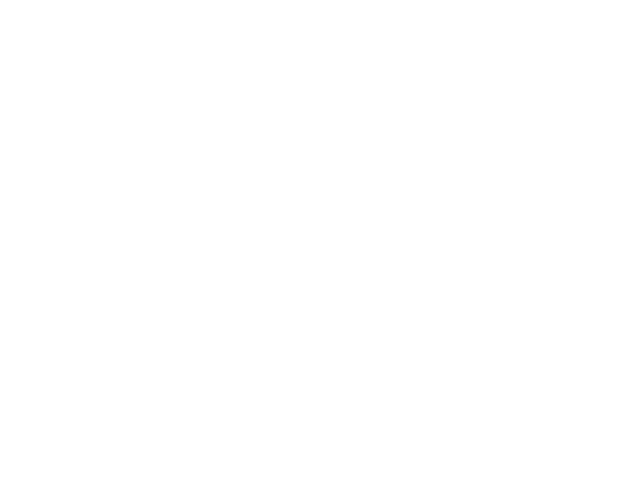

In [276]:

plt.figure()
plt.plot(eta_ts.t, eta_ts.y.ravel(), lw=0.2)
plt.plot(eta_ts.t, h_D1D2_full,'k')
plt.plot(eta_ts.t, h_D2_full,'b')

plt.ylabel('$\zeta$ [m]')

plt.xticks(rotation=17)
#plt.ylim(0,3.0)
plt.ylim(0,0.5)


ax2=plt.twinx()
p2,=plt.plot(a0_harmonic.timeslow, a0_harmonic.values,'r.')
ax2.set_ylabel('$a_0$ [m]')
#plt.xlim(datetime(2016,5,1),datetime(2017,5,1))

plt.tight_layout()

In [23]:
from theano.compile.ops import as_op

@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dvector])
def lagtimeseries_pm(x0, y0, lag):
    """
    x0 input x coordinate
    y0 input y coordinate
    
    x lagged value
    """
    x =  x0 - lag
    
    # Check the bounds
    x[x<x0[0]]=x0[0]
    x[x>x0[-1]]=x0[-1]

    idx = tt.extra_ops.searchsorted(x0, x).eval()
    
    #return y0[idx - 1]

    dl = x - x0[idx - 1]
    dr = x0[idx] - x
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

def sine_model_envelope_pm(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    result = tt.zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = tt.zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
    return pm.math.sqrt(result*result + result_i*result_i)


timestamp = datetime.now().strftime('%Y-%m-%d')
# Harmonic a0
#lag = 1.6
Y = a0_harmonic.values
tdays = shared(tdays_a0)
beta_shared = shared(beta_s)
scale_shared = shared(scalefac.values)
outputh5 = '../inputs/a0_samples_harmonic_a0_all_times_{}.h5'.format(timestamp)
#outputh5 = '../inputs/a0_samples_harmonic_a0_variable_lag_{}.h5'.format(timestamp)
nt = tdays_a0.shape[0]


with pm.Model() as model:
    
    # Scale
    omega_A = 2*np.pi/365.
    omega_SA = 2*np.pi/182.5


    #alpha1 = pm.HalfNormal('alpha1', 10)
    
    # Varying error on the slope (Hierarchical)
    #alpha_mu = pm.Normal('alpha_mu', 0,10)
    #alpha1 = pm.Normal('alpha1', alpha_mu,1, shape=nt)
    
    
    aa = pm.Normal('aa', mu=0, sd=2)
    Aa = pm.Normal('Aa', mu=0, sd=2,shape=2)
    Ba = pm.Normal('Ba', mu=0, sd=2,shape=2)
    alpha1 = pm.Deterministic('alpha1',aa + Aa[0]*pm.math.cos(omega_A*tdays) + Ba[0]*pm.math.sin(omega_A*tdays)+\
                      Aa[1]*pm.math.cos(omega_SA*tdays) + Ba[1]*pm.math.sin(omega_SA*tdays))
    
    #alpha2 = pm.HalfCauchy('alpha2', 10)
    #alpha3 = pm.HalfCauchy('alpha3', 10)

    
    # offset
    beta = pm.HalfNormal('beta', 10) 
    
    # error
    sd = pm.HalfNormal('sd', 10)

    
    
    #coeff_sd = pm.HalfNormal('sd_coeff', 1)

    # lag
    #ylag = lagtimeseries_pm(tt.as_tensor(tdays), tt.as_tensor(h_env), lag)


    #lag=2.02
    # Scalar lag
    #ylag = lagtimeseries(tdays, h_env, lag)
    
    # Non-scalar lag
    #lag = pm.HalfCauchy('lag', 10.0)
    #lag = pm.Normal('lag', mu=4., sd=0.5)
    
    # Lag as a time series
    al = pm.Normal('al', mu=0, sd=5)
    Al = pm.Normal('Al', mu=0, sd=2,shape=2)
    Bl = pm.Normal('Bl', mu=0, sd=2,shape=2)
    lag = pm.Deterministic('lag',al + Al[0]*pm.math.cos(omega_A*tdays) + Bl[0]*pm.math.sin(omega_A*tdays)+\
        Al[1]*pm.math.cos(omega_SA*tdays) + Bl[1]*pm.math.sin(omega_SA*tdays))

    #ylag = lagtimeseries_pm(tt.as_tensor(tdays), tt.as_tensor(h_env), lag)
    
    # Alternative approach is to compute the lagged envelope function directly
    tsec = (tdays-lag)*86400.
    #ylag = sine_model_envelope_pm(beta_s, omega, tsec)
    ylag = (sine_model_envelope_pm(beta_shared[0:8], omega[0:4], tsec) + \
        sine_model_envelope_pm(beta_shared[8:], omega[4:], tsec))*scale_shared
    #ylag = pm.Deterministic('ylag',sine_model_envelope_pm(beta_s, omega, tsec))

    #ylag
    #lag = lagtimeseries_pm(tdays, h_env, lag)
    # This is not really necessary
    #ylag = pm.Deterministic('ylag', sine_model_envelope_pm(beta_s, omega, tsec))


    
    # Mean function
    #mu = pm.Deterministic('mu', alpha1*ylag + beta)
    # Cubic polynomial
    #mu = pm.Deterministic('mu', alpha3*ylag*ylag*ylag + alpha2*ylag*ylag + alpha1*ylag + beta)
    
    
    #vals = pm.Normal('vals', alpha1*ylag + beta, sd=sd, observed=Y)
    vals = pm.Gamma('vals', mu=alpha1*ylag + beta, sd=sd, observed=Y)

    #BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    #BoundedNormal('vals', alpha1*ylag + beta, sd=sd, observed=Y)
    
    #start = {'lag':1.}
    #start= pm.find_MAP()
    start=None
    #step1 = pm.Metropolis(vars=[lag])
    #step2 = pm.NUTS(vars=[alpha1,beta,sd])
    trace = pm.sample(500, tune=1500,step = pm.NUTS(), start=start, chains=4)
    #trace = pm.sample(500, tune=1500,step =[step1,step2], start=start, chains=1)

    #print(pm.find_MAP())
    
    
pm.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bl, Al, al, sd, beta, Ba, Aa, aa]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:19<00:00, 100.31draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
aa,0.228744,0.009537,0.000228,0.211062,0.248252,1759.004022,1.001111
Aa__0,-0.032071,0.005005,0.000097,-0.041693,-0.022461,2751.133087,0.999388
Aa__1,-0.012027,0.004763,0.000087,-0.022207,-0.003511,2533.775707,1.001261
Ba__0,-0.004208,0.004853,0.000090,-0.013745,0.005364,2402.382524,0.999332
Ba__1,-0.044251,0.004970,0.000104,-0.053070,-0.033528,2471.730706,0.999061
al,1.591289,0.104542,0.001971,1.393669,1.798443,2472.217592,0.999312
Al__0,0.908402,0.159536,0.002926,0.586756,1.209653,2616.087211,0.999122
Al__1,0.859993,0.144636,0.002606,0.588667,1.151059,2840.621553,0.999123
Bl__0,0.213644,0.128027,0.002708,-0.023991,0.466652,2244.416934,0.999113
Bl__1,0.077286,0.142105,0.002567,-0.198678,0.348462,2801.570666,0.999398


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


<IPython.core.display.Javascript object>


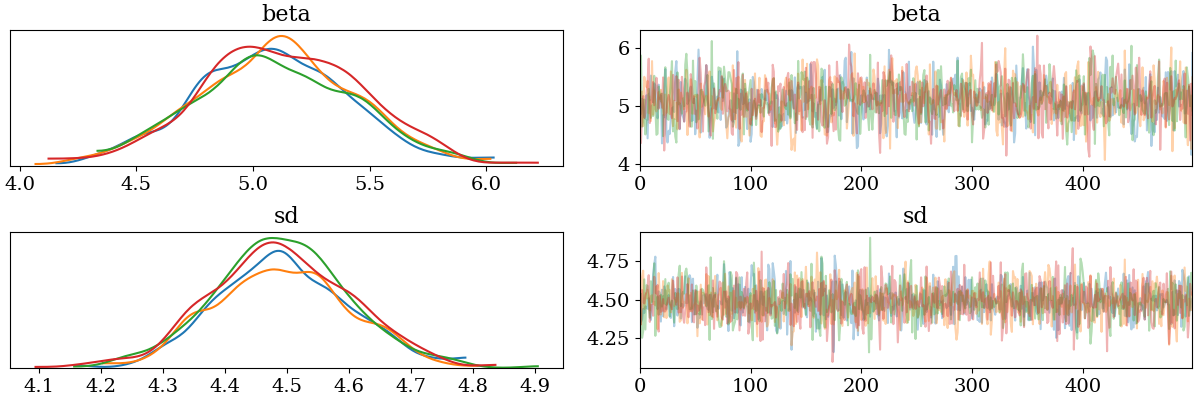

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa170cc4358>,
      dtype=object)

In [24]:
pm.traceplot(trace,var_names=['beta','sd'])

<IPython.core.display.Javascript object>


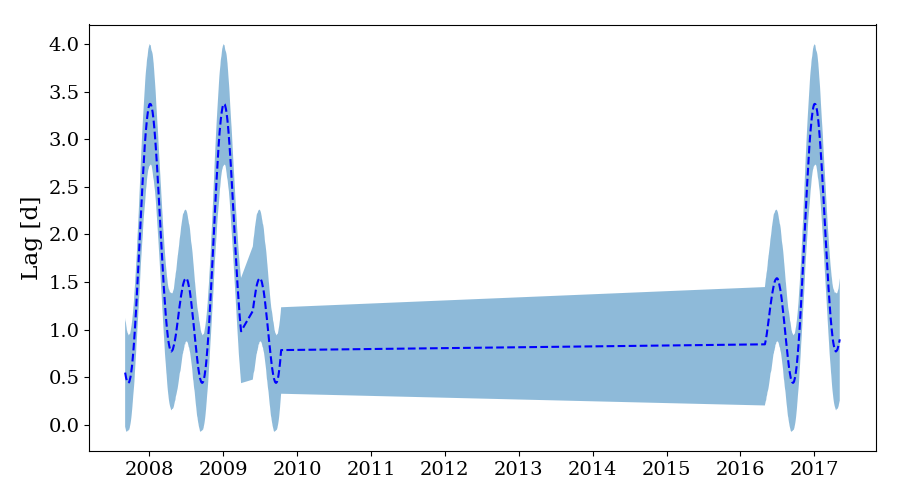

In [25]:
plt.figure(figsize=(9,5))
p1,=plt.plot(a0_harmonic.timeslow.values, np.median(trace['lag'],axis=0),'b--')
plt.fill_between(a0_harmonic.timeslow.values, np.percentile(trace['lag'],0.5,axis=0),\
                 np.percentile(trace['lag'],99.5,axis=0),alpha=0.5)
trace['lag'].shape
plt.ylabel('Lag [d]')
plt.tight_layout()

<IPython.core.display.Javascript object>


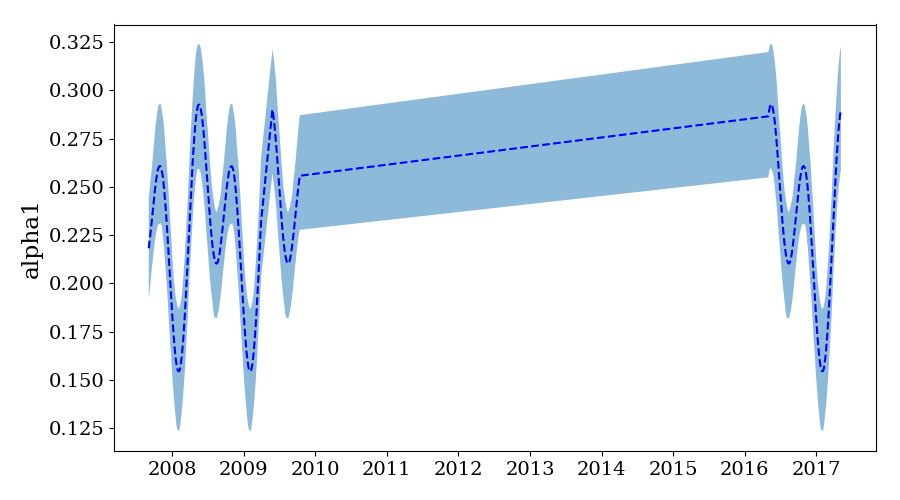

In [26]:
plt.figure(figsize=(9,5))
p1,=plt.plot(a0_harmonic.timeslow.values, np.median(trace['alpha1'],axis=0),'b--')
plt.fill_between(a0_harmonic.timeslow.values, np.percentile(trace['alpha1'],0.5,axis=0),\
                 np.percentile(trace['alpha1'],99.5,axis=0),alpha=0.5)
plt.ylabel('alpha1')
plt.tight_layout()

In [27]:
#tnew = rhotime
#tsecnew = SecondsSince(tnew,basetime=basetime)
#tdaynew = tsecnew/86400.
#tdays.set_value(tdaynew)

tnew = a0_harmonic.timeslow.values
# Use the built-in function for prediction
nsamples = 1000
ppc = pm.sample_posterior_predictive(trace, model=model, samples=nsamples)

a0_pred = ppc['vals']

100%|██████████| 1000/1000 [00:13<00:00, 72.91it/s]


<IPython.core.display.Javascript object>


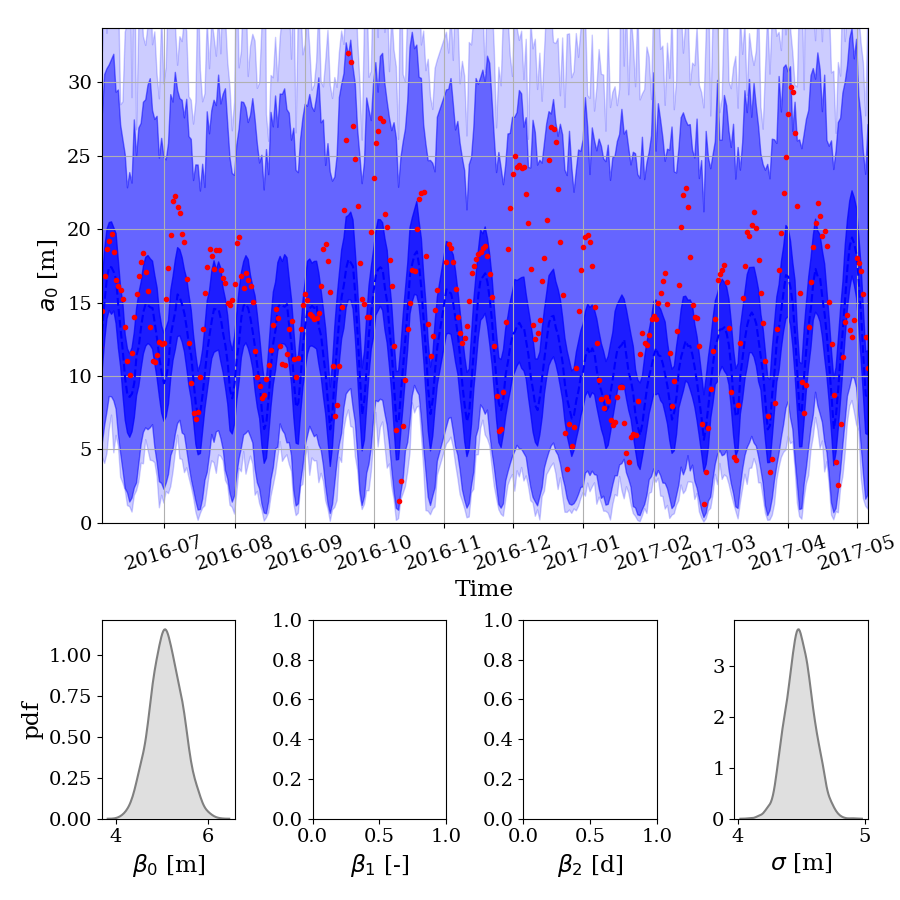

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


In [28]:
plt.figure(figsize=(9,9))

plt.subplot2grid((3,4),(0,0), rowspan=2,colspan=4)
#plt.plot(tdays, np.median(samples['vals'],axis=0),'k--')
#plt.fill_between(tdays, np.percentile(samples['vals'],1.0,axis=0),\
#                 np.percentile(samples['vals'],99.,axis=0),alpha=0.5)

p1,=plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
plt.fill_between(tnew, np.percentile(a0_pred,25,axis=0),\
                 np.percentile(a0_pred,75,axis=0),color='b',alpha=0.7)
plt.fill_between(tnew, np.percentile(a0_pred,0.5,axis=0),\
                 np.percentile(a0_pred,99.5,axis=0),color='b',alpha=0.5)
plt.fill_between(tnew, np.min(a0_pred,axis=0),\
                 np.max(a0_pred,axis=0),color='b',alpha=0.2)

#plt.fill_between(tnew, np.min(a0_pred2,axis=0),\
#                 np.max(a0_pred2,axis=0),alpha=0.5)

#plt.plot(data.index.values,data.a0.values,'m.')
p2,=plt.plot(a0_harmonic.timeslow, a0_harmonic.values,'r.')


#ax2 = plt.twinx()
#ax2.plot(tdays,h_env,'g--')

plt.xlim(tnew[0],tnew[-1])
plt.ylim(0,40)
plt.ylabel('$a_0$ [m]')
plt.xlabel('Time')
plt.xticks(rotation=17)
plt.grid(b=True)
plt.tight_layout()

ax=plt.subplot2grid((3,4),(2,0),)
sns.kdeplot(trace['beta'], shade=True, c='0.5')
plt.xlabel(r'$\beta_0$ [m]')
plt.ylabel('pdf')

ax=plt.subplot2grid((3,4),(2,1),)
#sns.kdeplot(trace['alpha1'], shade=True, c='0.5')
plt.xlabel(r'$\beta_1$ [-]')

ax=plt.subplot2grid((3,4),(2,2),)
#sns.kdeplot(trace['lag'], shade=True, c='0.5')
plt.xlabel(r'$\beta_2$ [d]')

ax=plt.subplot2grid((3,4),(2,3),)
sns.kdeplot(trace['sd'], shade=True, c='0.5')
plt.xlabel(r'$\sigma$ [m]')

plt.tight_layout()

outfile = '../FIGURES/a0_mcmc_series'
#outfile = '../FIGURES/a0optimize_mcmc_serie

In [41]:
# Make a prediction and save the data
densityh5file = '../../run_ddcurves/DATA_SHELL/ShellFBlock_Unfiltered_Density_BHM_VI_20072009.h5'
outputh5 = '../inputs/a0_samples_FBlock_gammadist_20072009_{}.h5'.format(timestamp)


with h5py.File(densityh5file,'r') as f:
    rhotime_fblock = f['data/time'][:].astype('<M8[ns]')
    
    
a0_harmonic_new = a0.sel(timeslow=rhotime_fblock, method='nearest')
c1new = cn.sel(timeslow=rhotime_fblock, method='nearest')
N2barnew = N2.mean(axis=1).sel(timeslow=rhotime_fblock, method='nearest')
                
scalefacnew = np.sqrt(H*np.sqrt(N2barnew)/(N2barnew*c1new))
print(outputh5)
print(rhotime_fblock.shape)

../inputs/a0_samples_FBlock_gammadist_20072009_2019-08-08.h5
(680,)


In [42]:
tnew = rhotime_fblock
tsecnew = SecondsSince(tnew,basetime=basetime)
tdaynew = tsecnew/86400.
tdays.set_value(tdaynew)


# Update the stratification dependent scalingb
scale_shared.set_value(scalefacnew.values)

# Use the built-in function for prediction
nsamples = 1000
ppc = pm.sample_posterior_predictive(trace, model=model, samples=nsamples)

a0_pred_new = ppc['vals']

100%|██████████| 1000/1000 [00:22<00:00, 43.85it/s]


<IPython.core.display.Javascript object>


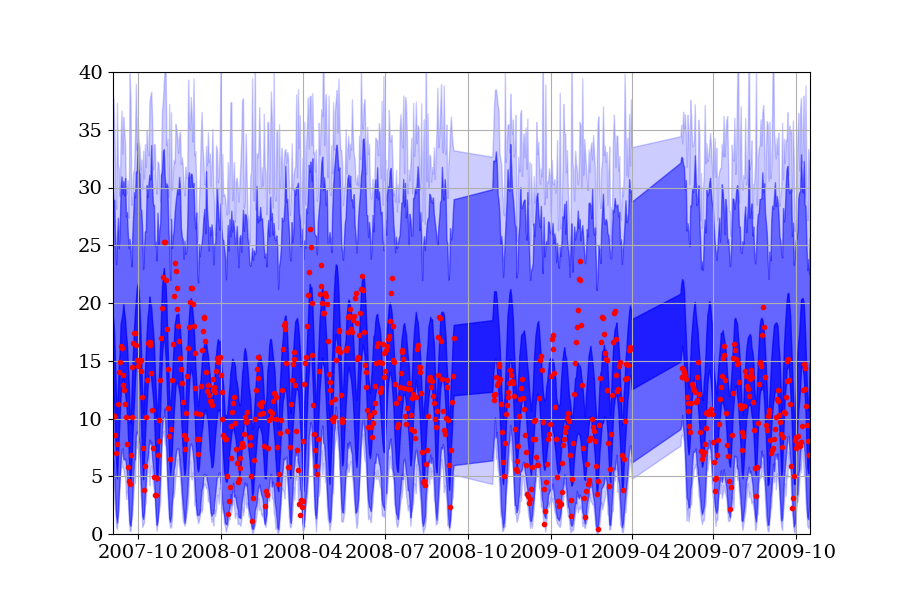

In [43]:
plt.figure(figsize=(9,6))

#plt.plot(tdays, np.median(samples['vals'],axis=0),'k--')
#plt.fill_between(tdays, np.percentile(samples['vals'],1.0,axis=0),\
#                 np.percentile(samples['vals'],99.,axis=0),alpha=0.5)

plt.fill_between(tnew, np.percentile(a0_pred_new,25,axis=0),\
                 np.percentile(a0_pred_new,75,axis=0),color='b',alpha=0.7)
plt.fill_between(tnew, np.percentile(a0_pred_new,0.5,axis=0),\
                 np.percentile(a0_pred_new,99.5,axis=0),color='b',alpha=0.5)
plt.fill_between(tnew, np.min(a0_pred_new,axis=0),\
                 np.max(a0_pred_new,axis=0),color='b',alpha=0.2)
#plt.fill_between(tnew, np.min(a0_pred2,axis=0),\
#                 np.max(a0_pred2,axis=0),alpha=0.5)

#plt.plot(data.index.values,data.a0.values,'m.')
p2,=plt.plot(a0_harmonic_new.timeslow, a0_harmonic_new.values,'r.')

plt.ylim(0,40)
plt.xlim(tnew[0],tnew[-1])
plt.grid(b=True)

In [46]:
f = h5py.File(outputh5,'w')
g = f.create_group('data')
g.create_dataset('a0-all-times-samples',data=a0_pred_new.T)
g.create_dataset('time',data=tnew.astype(int))
f.close()
print(outputh5, tnew.shape)

../inputs/a0_samples_FBlock_gammadist_20072009_2019-08-08.h5 (680,)


In [255]:
# Make a prediction with the KP150 data

ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motaion.nc'
mode=0
ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')


# Merge the two
A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

N2 = xr.concat([ds1['N2'][:],\
    ds2['N2'][:]],dim='timeslow')

cn = xr.concat([ds1['cn'][:,mode],\
    ds2['cn'][:,mode]],dim='timeslow')


# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan
a0.loc['2016-09-18':'2016-10-31']=np.nan

# Create a time series of single days with the max amplitude and a guess at beta
#time1 = pd.date_range('2016-5-1','2016-9-15') 
#time2 = pd.date_range('2016-11-1','2017-5-1')

#time = time1.append(time2)

a0_harmonic_new = a0[::4] #a0.sel(timeslow=data.index, method='nearest')
c1new = cn[::4]
N2barnew = N2.mean(axis=1)[::4]
                
scalefac = np.sqrt(H*np.sqrt(N2barnew)/(N2barnew*c1new))
a0.shape, scalefac.shape

((1472,), (368,))

In [256]:
# Need to update the tidal amplitudes
# Extract the tidal height for the whole period
time = TimeVector('20160501.000000','20170501.000000',3600)
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

th,sp = cart2pol(U,V)
Ur,Vr = pol2cart(th+45*np.pi/180,sp)

#eta_ts = timeseries(time,eta)
eta_ts = timeseries(time,Ur)


eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)


#h_re, h_im = pol2cart(hp,ha)
h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s_new = np.zeros((2*nf,))
beta_s_new[0:-1:2] = h_re.ravel()
beta_s_new[1::2] = h_im.ravel()
beta_s, beta_s_new

Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


(array([ 7.71835217e-02, -2.10572396e-01,  1.02783098e-01,  1.25833828e-01,
         2.32621568e-02, -2.99506959e-02, -5.40195547e-02, -1.73871061e-02,
         1.03234500e-02,  3.33552992e-02,  2.09572709e-02,  6.31320510e-03,
         1.09563951e-04,  7.66555806e-03,  1.66568092e-03,  4.18150460e-03]),
 array([ 8.77085462e-02, -2.24311751e-01,  1.02641406e-01,  1.25950312e-01,
         2.56393577e-02, -3.16424295e-02, -2.91369652e-02, -1.52781903e-02,
         6.06339716e-03,  2.72187460e-02,  1.48307778e-02,  2.87103712e-03,
         1.16438438e-04,  7.66548187e-03,  1.44472771e-03,  2.76665855e-03]))

In [257]:
basetime

datetime.datetime(2007, 1, 1, 0, 0)

In [258]:
tnew = a0_harmonic_new.timeslow.values

tsecnew = SecondsSince(tnew,basetime=basetime)
tdaynew = tsecnew/86400.
tdays.set_value(tdaynew)

# Update the tidal amplitude coefficients
beta_shared.set_value(beta_s_new)

# Update the stratification dependent scaling
scale_shared.set_value(scalefac.values)

# Use the built-in function for prediction
nsamples = 1000
ppc = pm.sample_posterior_predictive(trace, model=model, samples=nsamples)

a0_pred_new = ppc['vals']

100%|██████████| 1000/1000 [00:21<00:00, 46.88it/s]


<IPython.core.display.Javascript object>


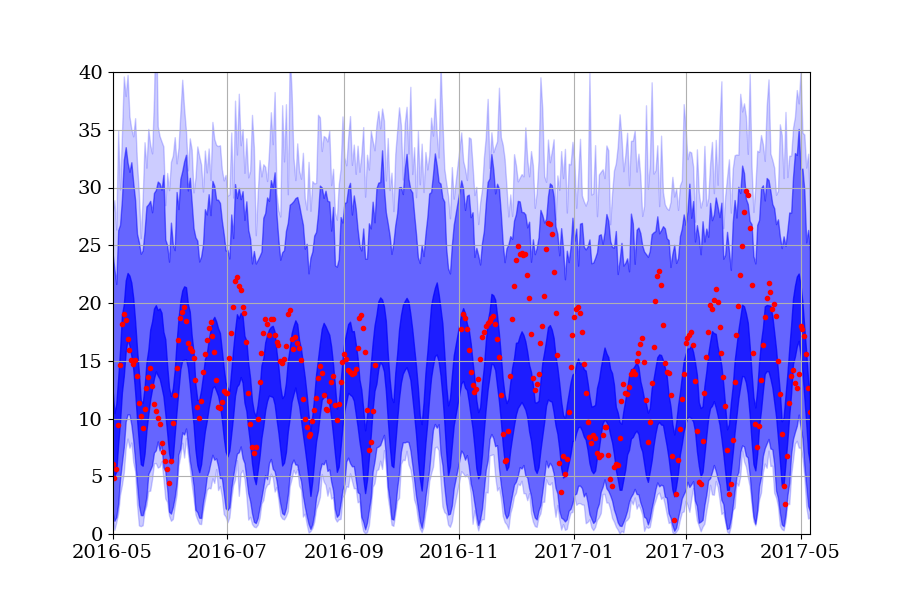

In [261]:
plt.figure(figsize=(9,6))

#plt.plot(tdays, np.median(samples['vals'],axis=0),'k--')
#plt.fill_between(tdays, np.percentile(samples['vals'],1.0,axis=0),\
#                 np.percentile(samples['vals'],99.,axis=0),alpha=0.5)

plt.fill_between(tnew, np.percentile(a0_pred_new,25,axis=0),\
                 np.percentile(a0_pred_new,75,axis=0),color='b',alpha=0.7)
plt.fill_between(tnew, np.percentile(a0_pred_new,0.5,axis=0),\
                 np.percentile(a0_pred_new,99.5,axis=0),color='b',alpha=0.5)
plt.fill_between(tnew, np.min(a0_pred_new,axis=0),\
                 np.max(a0_pred_new,axis=0),color='b',alpha=0.2)
#plt.fill_between(tnew, np.min(a0_pred2,axis=0),\
#                 np.max(a0_pred2,axis=0),alpha=0.5)

#plt.plot(data.index.values,data.a0.values,'m.')
p2,=plt.plot(a0_harmonic_new.timeslow, a0_harmonic_new.values,'r.')

plt.ylim(0,40)
plt.xlim(tnew[0],tnew[-1])
plt.grid(b=True)